In [69]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [54]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

# Goal

Calculate ci metrics for each release and output a dataset with one entry for release and a list of metrics as features

In [4]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.Date = pd.to_datetime(tags.Date)
tags.head(2)

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7


### Import builds and jobs

In [5]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)
builds.head(2)

,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,6995,NaN,99118995,push,2015-12-28 16:34:08+00:00,NaN,2015-12-28 16:18:41+00:00,5361.0,failed,28.0,12.0,2015.0
1,6994,NaN,99100662,push,2015-12-28 14:36:03+00:00,NaN,2015-12-28 14:18:30+00:00,5953.0,passed,28.0,12.0,2015.0


In [6]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs.shape

(136983, 13)

### Import tag comparison pairs

In [7]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison = tags_comparison[2:]
tags_comparison[["from_tag", "to_tag"]]

,from_tag,to_tag
2,5.1.1,5.1.2
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
10,5.6.1,6.0
11,5.6.2,5.6.3


## Import release commits

In [8]:
def replace_tags_with_jira(df):
    df = df.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
    .drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
    df = df.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
    .drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
    return df

### Import tags difference commits (git log tag1...tag2) (1)

In [9]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones.csv", index_col=0)
tags_comparison_commits.tail(2)

,from_tag,to_tag,ahead_sha
15603,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df
15604,8.4.1.35646,8.4.2.36762,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6


In [10]:
tags_comparison_commits  = replace_tags_with_jira(tags_comparison_commits)
tags_comparison_commits.rename(columns={"ahead_sha": "commitsha"}, inplace=True)
tags_comparison_commits.tail(2)

,commitsha,to_tag,from_tag
15603,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1
15604,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6,8.4.2,8.4.1


In [11]:
tags_comparison_commits.shape

(15605, 3)

### Import tags commits (1) + iterative PRs

In [12]:
tags_iterative_pr_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_pairs_iterative_commits.csv", index_col=0)
tags_iterative_pr_commits.tail(2)

,from_tag,to_tag,commitsha
122451,8.4.1.35646,8.4.2.36762,ed1a72601c559e86ccd96004c99157421b6bcb20
122452,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df


In [13]:
tags_iterative_pr_commits  = replace_tags_with_jira(tags_iterative_pr_commits)
tags_iterative_pr_commits.tail(2)

,commitsha,to_tag,from_tag
122451,ed1a72601c559e86ccd96004c99157421b6bcb20,8.4.2,8.4.1
122452,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1


In [14]:
tags_iterative_pr_commits.shape

(122453, 3)

### Import tags commits the ones nor in (1) or (2) assigned using Jira FixVersion for the issue in commitmessage

In [15]:
tags_fix_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_fix_commits.csv", index_col=0)
tags_fix_commits.tail(2)

,from_tag,to_tag,commitsha
3245,8.4,8.4.1,34a0bc1a4e14e13a7d40a410b268d6ea7b0f3a40
3246,8.4.1,8.4.2,df64c184d1427f74592459b42093e8b0b6878c98


In [16]:
tags_fix_commits.shape

(3247, 3)

# Start

In [17]:
def get_builds_from_commits(_commits):
    _build_ids = jobs[jobs.commitsha.isin(_commits)].buildid
    return builds[(builds.id.isin(_build_ids))]

def get_builds_from_ids(_builds, _build_ids):
    return _builds[(_builds.id.isin(_build_ids))]

def get_commits_from_comparison_row(row, commitsDf):
    _x = commitsDf
    return _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha

### Builds metrics

**Number of jobs per build**

In [18]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_n_job_per_build(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return _jobs.groupby("buildid").id.count().mean()

def calculate_average_n_job_per_build_pr(row):
    return calculate_average_n_job_per_build(row, tags_iterative_pr_commits)
def calculate_average_n_job_per_build_direct(row):
    return calculate_average_n_job_per_build(row, tags_comparison_commits)
def calculate_average_n_job_per_build_fix(row):
    return calculate_average_n_job_per_build(row, tags_fix_commits)
def calculate_average_n_job_per_build_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_n_job_per_build(row, _tmp)

In [19]:
tags_comparison["average_n_job_per_build"] = tags_comparison.apply(calculate_average_n_job_per_build_pr_and_fix, axis=1)

KeyboardInterrupt: 

In [ ]:
sns.barplot(x=tags_comparison["average_n_job_per_build"].index, \
            y=tags_comparison["average_n_job_per_build"].values)

**Number of builds per pull request**

In [ ]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_pr_builds(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    _builds = _all_builds[(_all_builds.event_type == "pull_request")]
    return len(_builds)/len(_all_builds)

def calculate_percentage_pr_builds_pr(row):
    return calculate_percentage_pr_builds(row, tags_iterative_pr_commits)
def calculate_percentage_pr_builds_direct(row):
    return calculate_percentage_pr_builds(row, tags_comparison_commits)
def calculate_percentage_pr_builds_fix(row):
    return calculate_percentage_pr_builds(row, tags_fix_commits)
def calculate_percentage_pr_builds_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_pr_builds(row, _tmp)

In [ ]:
tags_comparison["percentage_pr_builds"] = tags_comparison.apply(calculate_percentage_pr_builds_pr_and_fix, axis=1)

In [ ]:
sns.barplot(x=tags_comparison["percentage_pr_builds"].index, \
            y=tags_comparison["percentage_pr_builds"].values)

In [ ]:
tags_comparison[tags_comparison.percentage_pr_builds == 0.4]

In [ ]:
tags_comparison[tags_comparison.percentage_pr_builds == 0][["from_tag", "to_tag"]]

* 0% pull request builds may indicate mostly bug fixing done directly on the version branch. 
Indeed all the pairs with 0% do not represent major version upgrades

**Average build duration**

In [ ]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_build_duration(row, commitsDf, state=None):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    if(not state):
        return _all_builds.duration.mean()
    return _all_builds[_all_builds.state==state].duration.mean()

def calculate_average_build_duration_pr(row):
    return calculate_average_build_duration(row, tags_iterative_pr_commits)
def calculate_average_build_duration_direct(row):
    return calculate_average_build_duration(row, tags_comparison_commits)
def calculate_average_build_duration_fix(row):
    return calculate_average_build_duration(row, tags_fix_commits)
def calculate_average_build_duration_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_build_duration(row, _tmp)
def calculate_average_passed_build_duration_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_build_duration(row, _tmp, "passed")

In [ ]:
tags_comparison["average_build_duration"] = tags_comparison.apply(calculate_average_build_duration_pr_and_fix, axis=1)

In [ ]:
sns.barplot(x=tags_comparison["average_build_duration"].index, \
            y=tags_comparison["average_build_duration"].values)
plt.show()

In [ ]:
tags_comparison["average_passed_build_duration"] = tags_comparison.apply(calculate_average_passed_build_duration_pr_and_fix, axis=1)

In [ ]:
sns.barplot(x=tags_comparison["average_passed_build_duration"].index, \
            y=tags_comparison["average_passed_build_duration"].values)
plt.show()

### Jobs metrics

**Average job duration**

In [ ]:
jobs["duration"] = (jobs.finished_at - jobs.started_at) / np.timedelta64(1, "s")

In [ ]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_job_duration(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    return _jobs.duration.mean()

def calculate_average_job_duration_pr(row):
    return calculate_average_job_duration(row, tags_iterative_pr_commits)
def calculate_average_job_duration_direct(row):
    return calculate_average_job_duration(row, tags_comparison_commits)
def calculate_average_job_duration_fix(row):
    return calculate_average_job_duration(row, tags_fix_commits)

In [ ]:
tags_comparison["mean_job_duration_builds_passed_or_failed"] = tags_comparison.apply(calculate_average_job_duration_pr, axis=1)

**Average failed jobs per commit**

In [ ]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_failed_job_per_commit(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    _jobs = _jobs[_jobs.state == "failed"]
    return _jobs.groupby("commitsha").state.count().mean()

def calculate_average_failed_job_per_commit_pr(row):
    return calculate_average_failed_job_per_commit(row, tags_iterative_pr_commits)
def calculate_average_failed_job_per_commit_direct(row):
    return calculate_average_failed_job_per_commit(row, tags_comparison_commits)
def calculate_average_failed_job_per_commit_fix(row):
    return calculate_average_failed_job_per_commit(row, tags_fix_commits)
def calculate_average_failed_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_failed_job_per_commit(row, _tmp)

In [ ]:
tags_comparison["average_failed_job_per_commit"] = tags_comparison.apply(calculate_average_failed_job_per_commit_pr, axis=1)

In [ ]:
sns.barplot(x=tags_comparison["average_failed_job_per_commit"].index, \
            y=tags_comparison["average_failed_job_per_commit"].values)

**Number of jobs per pull request**

In [ ]:
### Mean or median of number of jobs per pull request
def calculate_median_n_job_per_pull_request(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.commitref.str.contains("refs/pull/")]
    return _jobs.groupby("commitref").id.count().median()
    
def calculate_median_n_job_per_pull_request_per_commit_pr(row):
    return calculate_median_n_job_per_pull_request(row, tags_iterative_pr_commits)
def calculate_median_n_job_per_pull_request_per_commit_direct(row):
    return calculate_median_n_job_per_pull_request(row, tags_comparison_commits)
def calculate_median_n_job_per_pull_request_per_commit_fix(row):
    return calculate_median_n_job_per_pull_request(row, tags_fix_commits)
def calculate_median_n_job_per_pull_request_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_median_n_job_per_pull_request(row, _tmp)

In [ ]:
tags_comparison["median_n_job_per_pull_request"] =\
tags_comparison.apply(calculate_median_n_job_per_pull_request_per_commit_pr_and_fix, axis=1)

In [ ]:
sns.barplot(x=tags_comparison["median_n_job_per_pull_request"].index, \
            y=tags_comparison["median_n_job_per_pull_request"].values)

**Median number of jobs per commitmessage (if starting with SONAR-)**

In [ ]:
### Mean or median of number of jobs per pull request
def calculate_median_n_job_per_commitmessage(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return _jobs.groupby("commitmessage").id.count().median()
    
def calculate_median_n_job_per_commitmessage_per_commit_pr(row):
    return calculate_median_n_job_per_commitmessage(row, tags_iterative_pr_commits)
def calculate_median_n_job_per_commitmessage_per_commit_direct(row):
    return calculate_median_n_job_per_commitmessage(row, tags_comparison_commits)
def calculate_median_n_job_per_commitmessage_per_commit_fix(row):
    return calculate_median_n_job_per_commitmessage(row, tags_fix_commits)
def calculate_median_n_job_per_commitmessage_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_median_n_job_per_commitmessage(row, _tmp)

In [ ]:
tags_comparison["median_n_job_per_commitmessage"] =\
tags_comparison.apply(calculate_median_n_job_per_commitmessage_per_commit_pr_and_fix, axis=1)

In [ ]:
sns.barplot(x=tags_comparison["median_n_job_per_commitmessage"].index, \
            y=tags_comparison["median_n_job_per_commitmessage"].values)

**Number of jobs canceled or errored**

In [ ]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_canceled_or_errored_job(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return len(_jobs[_jobs.state.isin(["canceled", "errored"])]) / len(_jobs)

def calculate_percentage_canceled_or_errored_job_per_commit_pr(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_iterative_pr_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_direct(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_comparison_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_fix(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_fix_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_canceled_or_errored_job(row, _tmp)

In [ ]:
tags_comparison["percentage_canceled_or_errored_job"] =\
tags_comparison.apply(calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix, axis=1)

In [ ]:
sns.barplot(x=tags_comparison["percentage_canceled_or_errored_job"].index, \
            y=tags_comparison["percentage_canceled_or_errored_job"].values)

**Is commitsha and commitref identical for all jobs associated with the same buildid?**

In [ ]:
(jobs.groupby("buildid").commitsha.nunique() > 1).sum()

In [ ]:
(jobs.groupby("buildid").commitref.nunique() > 1).sum()

Yes, therefore we can add this info to the build df

### Build burst metrics

In [ ]:
builds_commitref = jobs.drop_duplicates(subset=["buildid", "commitref", "commitsha"], keep="first")[["buildid", "commitref", "commitsha"]]\
.merge(builds, left_on="buildid", right_on="id")
builds_commitref.head(40)

In [ ]:
def detect_build_bursts(_builds, gap_size, burst_size, states):
    positive_count = 0
    negative_count = 0
    n_bursts = 0
    burst_sizes = []
    i = 0
    for index, row in _builds.sort_values(by="started_at").iterrows():
        i+=1
        if((i == len(_builds)) | (not (row.state in states))):
            negative_count+=1
            if(negative_count == gap_size):
                if(positive_count >= burst_size):
                    n_bursts+=1
                    burst_sizes.append(positive_count)
                negative_count = 0
                positive_count = 0
        if(row.state in states):
            positive_count+=1
    return n_bursts, burst_sizes

def build_burst_metrics(row, states):
    _commits = get_commits_from_comparison_row(row, tags_iterative_pr_commits)
    _builds = get_builds_from_commits(_commits)
    _builds = builds_commitref[builds_commitref.id.isin(_builds.id)]
    res = {}
    for gap_size in [1,2,3]:
        for burst_size in [1,2,3]:
            commitref_data=[]
            for commitref in _builds.commitref.unique():
                _ref_builds = _builds[_builds.commitref==commitref]
                commitref_data.append(detect_build_bursts(_ref_builds, gap_size, burst_size, states))
            bursts = np.array([])
            bursts_sizes = np.array([])
            for d in commitref_data:
                bursts = np.append(bursts,d[0])
                for v in d[1]:
                    bursts_sizes = np.append(bursts_sizes,v)
            if not gap_size in res:
                res[gap_size] = {}
            res[gap_size][burst_size] = (bursts, bursts_sizes)
    return res

def get_failed_burst_metrics(row):
    return build_burst_metrics(row, ["failed"])

def get_canceled_burst_metrics(row):
    return build_burst_metrics(row, ["canceled"])

def get_not_passed_burst_metrics(row):
    return build_burst_metrics(row, ["failed", "canceled", "errored"])

In [ ]:
def burst_metrics_analysis(burst_metrics, type_str):
    cols = ["index"]
    data = []
    for i, row in burst_metrics.items():
        inner_data = [i]
        for gap in row:
            for burst_size in row[gap]:
                bursts = row[gap][burst_size][0]
                burst_sizes = row[gap][burst_size][1]
                inner_data.append(bursts.mean())
                inner_data.append(np.median(bursts))
                inner_data.append(bursts.max())
                inner_data.append(bursts.min())
                if(i == 2):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_n_bursts_{metric}")
                inner_data.append(burst_sizes.mean())
                inner_data.append(np.median(burst_sizes))
                inner_data.append(np.max(burst_sizes, initial=0))
                inner_data.append(np.min(burst_sizes, initial=0))
                if(i == 2):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_burst_size_{metric}")
        data.append(tuple(inner_data))
    return data, cols

**Not passed burst metrics**

not_passed_burst_metrics = tags_comparison.apply(get_not_passed_burst_metrics,axis=1)

not_passed_burst_metrics.to_csv(f"{csv_folder}/not_passed_burst_metrics_raw.csv")

data, cols = burst_metrics_analysis(not_passed_burst_metrics, "not_passed")
not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
not_passed_burst_metrics_df.set_index("index", inplace=True)
not_passed_burst_metrics_df.shape

not_passed_burst_metrics_df.to_csv(f"{csv_folder}/not_passed_burst_metrics.csv")

In [ ]:
not_passed_burst_metrics_df = pd.read_csv(f"{csv_folder}/not_passed_burst_metrics.csv", index_col=0)
not_passed_burst_metrics_df.head(2)

**Canceled burst metrics**

canceled_burst_metrics = tags_comparison.apply(get_canceled_burst_metrics,axis=1)

data, cols = burst_metrics_analysis(canceled_burst_metrics, "canceled")
canceled_burst_metrics_df = pd.DataFrame(data, columns=cols)
canceled_burst_metrics_df.set_index("index", inplace=True)
canceled_burst_metrics_df.head(2)

canceled_burst_metrics_df.to_csv(f"{csv_folder}/canceled_burst_metrics.csv")

In [ ]:
canceled_burst_metrics_df = pd.read_csv(f"{csv_folder}/canceled_burst_metrics.csv", index_col=0)
canceled_burst_metrics_df.head(2)

**Failed burst metrics**

failed_burst_metrics = tags_comparison.apply(get_failed_burst_metrics,axis=1)

failed_burst_metrics.to_csv(f"{csv_folder}/failed_burst_metrics_raw.csv")

data, cols = burst_metrics_analysis(failed_burst_metrics, "failed")
failed_burst_metrics_df = pd.DataFrame(data, columns=cols)
failed_burst_metrics_df.set_index("index", inplace=True)
failed_burst_metrics_df.head(2)

failed_burst_metrics_df.to_csv(f"{csv_folder}/failed_burst_metrics.csv")

In [ ]:
failed_burst_metrics_df = pd.read_csv(f"{csv_folder}/failed_burst_metrics.csv", index_col=0)
failed_burst_metrics_df.head(2)

**Merging metrics**

In [ ]:
tags_comparison_x = tags_comparison.merge(failed_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_x = tags_comparison_x.merge(not_passed_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_x = tags_comparison_x.merge(canceled_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_x.shape

In [ ]:
sw_quality_metrics= pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)
sw_quality_metrics.head(2)

In [ ]:
tags_comparison_x = tags_comparison_x.merge(sw_quality_metrics, left_on="to_tag", right_on="version_name")

In [ ]:
from scipy import stats

In [ ]:
tags_comparison_x = tags_comparison_x.drop(columns=['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag'])

### Spearman correlation with Number of post release bugs

In [ ]:
for col in tags_comparison_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_x.post_release_bugs)
    if((abs(corr) > 0.5) and (p_val < 0.05)):
        print(col, corr, p_val)

### Spearman correlation with Fix Time

In [ ]:
for col in tags_comparison_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_x.fix_time)
    if((abs(corr) > 0.4) and (p_val < 0.05)):
        print(col, corr, p_val)

In [ ]:
for col in tags_comparison_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_x.dde)
    if((abs(corr) > 0.55) and (p_val < 0.05)):
        print(col, corr, p_val)

In [ ]:
sns.lineplot(x=tags_comparison_x.not_passed_gp1_bs2_n_bursts_max, y=tags_comparison_x.post_release_bugs)

**First iteration**

In [ ]:
iteration = 1

In [ ]:
job_parsed1 = pd.read_csv(f"{csv_folder}/jobs_log_metrics{iteration}.csv", index_col=0)
job_parsed1 = job_parsed1.merge(jobs[["id", "state", "started_at"]], left_on="job_id", right_on="id")

In [ ]:
passed_failed = job_parsed1[job_parsed1.state.isin(["passed", "failed"])]
passed_failed.build_canceled_open_pr_on_branch = passed_failed.build_canceled_open_pr_on_branch.fillna(False)

In [ ]:
passed_failed[(passed_failed.tests_total == 0) &\
              (~passed_failed.build_canceled_open_pr_on_branch) &\
              (passed_failed.build_target.str.contains("WEB")) &\
             ~(passed_failed.build_tool.str.contains("mocha", na=False))]

**Iteration 2**

In [ ]:
iteration = 2

In [ ]:
job_parsed = pd.read_csv(f"{csv_folder}/jobs_log_metrics{iteration}.csv", index_col=0)
job_parsed = job_parsed.merge(jobs[["id", "state", "started_at"]], left_on="job_id", right_on="id")

In [ ]:
passed_failed = job_parsed[job_parsed.state.isin(["passed", "failed"])]
passed_failed.build_canceled_open_pr_on_branch = passed_failed.build_canceled_open_pr_on_branch.fillna(False)

In [ ]:
passed_failed[(passed_failed.tests_total == 0) &\
              (~passed_failed.build_canceled_open_pr_on_branch) &\
              (passed_failed.build_target.str.contains("WEB")) &\
             ~(passed_failed.build_tool.str.contains("mocha", na=False))]

In [ ]:
sns.boxplot(job_parsed.tests_total)

**Outliers for tests_total**

In [ ]:
job_parsed.loc[job_parsed.tests_total.idxmax()]

**Outliers for web tests**

In [ ]:
web_jobs = passed_failed[(~passed_failed.build_canceled_open_pr_on_branch) &\
              (passed_failed.build_target.str.contains("WEB"))]

In [ ]:
web_jobs.loc[web_jobs.tests_total.idxmax()]

We confirm that the outliers have the correct number of tests

**Failed maven builds**

In [ ]:
failed = job_parsed[job_parsed.state.isin(["failed"])]
failed

* 331808143 has casper tests
* 152744497 has an undetected failed test due to wrong regex

**Iteration 3**

In [ ]:
iteration = 3

job_parsed = pd.read_csv(f"{csv_folder}/jobs_log_metrics{iteration}.csv", index_col=0)
job_parsed = job_parsed.merge(jobs[["id", "state", "started_at"]], left_on="job_id", right_on="id")

passed_failed = job_parsed[job_parsed.state.isin(["passed", "failed"])]

In [ ]:
failed = job_parsed[job_parsed.state.isin(["failed"])]
failed[failed.tests_failed == 0]

In [ ]:
job_parsed

**Iteration 4**

After gradle migration

In [ ]:
iteration = 4

job_parsed = pd.read_csv(f"{csv_folder}/jobs_log_metrics{iteration}.csv", index_col=0)
job_parsed = job_parsed.merge(jobs, left_on="job_id", right_on="id")

passed_failed = job_parsed[job_parsed.state.isin(["passed", "failed"])]

Some labeled as maven?

In [ ]:
job_parsed[job_parsed.build_tool.str.contains("maven", na=False)]

In [ ]:
failed = job_parsed[job_parsed.state.isin(["failed"])]
failed[failed.tests_failed == 0]

In [ ]:
job_parsed[job_parsed.tests_total != (job_parsed.tests_passed + job_parsed.tests_failed + job_parsed.tests_skipped)]

In [ ]:
import random
job_parsed.loc[random.choices(job_parsed[job_parsed.tests_total > 0].index, k=10)]

We confirm the correctness of the tests results

**Iteration 5**

Before gradle migration

In [ ]:
iteration = 5

job_parsed = pd.read_csv(f"{csv_folder}/jobs_log_metrics{iteration}.csv", index_col=0)
job_parsed = job_parsed.merge(jobs, left_on="job_id", right_on="id")

passed_failed = job_parsed[job_parsed.state.isin(["passed", "failed"])]

In [ ]:
job_parsed.build_tool.value_counts()

**Sum of tests = to total**

In [ ]:
job_parsed[job_parsed.tests_total != (job_parsed.tests_passed + job_parsed.tests_failed + job_parsed.tests_skipped)]

In [ ]:
job_parsed.head()

In [ ]:
job_parsed["n_exceptions"] = job_parsed.exceptions.fillna("[]").apply(lambda x: len(ast.literal_eval(x)))

In [ ]:
job_parsed.loc[job_parsed.n_exceptions.idxmax()]

### Final iteration

**Small fixes**

job_parsed_2 = pd.read_csv(f"../../local_log_parsing/jobs_log_metrics_final.csv", index_col=0)

job_parsed_2 = new_parsing

job_parsed = pd.read_csv(f"{csv_folder}/job_log_parsed/final/jobs_log_metrics_final.csv", index_col=0)

job_parsed.set_index("job_id", inplace=True)
job_parsed_2.set_index("job_id", inplace=True)
job_parsed.update(job_parsed_2)
job_parsed = job_parsed.reset_index()

job_parsed.to_csv(f"{csv_folder}/job_log_parsed/final/jobs_log_metrics_final.csv")

In [150]:
job_parsed = pd.read_csv(f"{csv_folder}/job_log_parsed/final/jobs_log_metrics_final.csv", index_col=0)
#
job_parsed.exceptions = job_parsed.exceptions.apply(ast.literal_eval)
job_parsed.error_classes = job_parsed.error_classes.apply(ast.literal_eval)
job_parsed.failed_tasks = job_parsed.failed_tasks.apply(ast.literal_eval)
job_parsed["build_tool_str"] = job_parsed.build_tool
job_parsed.build_tool = job_parsed.build_tool.apply(ast.literal_eval)
#
job_parsed = job_parsed.merge(jobs, left_on="job_id", right_on="id")

In [151]:
job_parsed["n_exceptions"] = job_parsed.exceptions.apply(lambda x: len(x))
job_parsed["n_error_classes"] = job_parsed.error_classes.apply(lambda x: len(x))
job_parsed["n_build_tools"] = job_parsed.build_tool.apply(lambda x: len(x))

In [152]:
job_parsed["year_month"] = job_parsed.apply(lambda row: f"{row.started_at.year}/{str(row.started_at.month).zfill(2)}", axis=1)
job_parsed["maven_build"] = job_parsed.build_tool.apply(lambda x: "maven" in x)
job_parsed["gradle_build"] = job_parsed.build_tool.apply(lambda x: "gradle" in x)
job_parsed["mocha_build"] = job_parsed.build_tool.apply(lambda x: "mocha" in x)
job_parsed["jest_build"] = job_parsed.build_tool.apply(lambda x: "jest" in x)
job_parsed["grunt_build"] = job_parsed.build_tool.apply(lambda x: "grunt" in x)
job_parsed["yarn_build"] = job_parsed.build_tool.apply(lambda x: "yarn" in x)
job_parsed["node_build"] = job_parsed.build_tool.apply(lambda x: "node" in x)

In [154]:
job_parsed.columns

Index(['job_id', 'build_target', 'build_tool',
       'build_canceled_open_pr_on_branch', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped', 'failed_tasks', 'build_tool_str', 'id',
       'buildid', 'started_at', 'created_at', 'finished_at', 'number', 'state',
       'updated_at', 'commitsha', 'commitid', 'commitmessage', 'commitref',
       'commitcompare_url', 'n_exceptions', 'n_error_classes', 'n_build_tools',
       'year_month', 'maven_build', 'gradle_build', 'mocha_build',
       'jest_build', 'grunt_build', 'yarn_build', 'node_build'],
      dtype='object')

In [155]:
jobs.shape

(136983, 13)

In [156]:
job_parsed.shape

(136983, 43)

In [157]:
job_parsed = job_parsed.drop_duplicates(subset=["job_id"], keep='first')
job_parsed.shape

(136983, 43)

**Describe**

In [158]:
job_parsed.describe()

,job_id,errors,failures,suspected_words,warnings,skipped_words,lines,words,tests_total,tests_passed,tests_failed,tests_skipped,id,buildid,number,commitid,n_exceptions,n_error_classes,n_build_tools
count,1.369830e+05,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,1.369830e+05,136983.000000,136983.000000,136983.000000,136983.000000,1.369830e+05,1.369830e+05,136983.000000,1.369830e+05,136983.000000,136983.000000,136983.000000
mean,1.605672e+08,392.526868,350.997080,34.361906,119.294489,395.542805,8013.431594,5.093868e+04,2226.271165,2223.497470,0.393027,2.380668,1.605672e+08,1.605672e+08,14131.256792,4.639438e+07,17.532424,0.769913,1.050846
std,9.339884e+07,750.253759,728.512991,144.815604,249.359894,672.734628,10409.808351,6.733393e+04,4294.403881,4294.076858,8.738932,8.219820,9.339884e+07,9.339884e+07,10802.638198,2.808363e+07,41.049539,6.010763,0.874099
min,5.473113e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,5.473113e+07,5.473112e+07,1.100000,1.569590e+07,0.000000,0.000000,0.000000
25%,8.808975e+07,1.000000,1.000000,1.000000,1.000000,0.000000,885.000000,3.007000e+03,0.000000,0.000000,0.000000,0.000000,8.808975e+07,8.808973e+07,5702.850000,2.505123e+07,0.000000,0.000000,1.000000
50%,1.280068e+08,7.000000,7.000000,6.000000,39.000000,53.000000,3992.000000,1.845800e+04,64.000000,62.000000,0.000000,0.000000,1.280068e+08,1.280068e+08,9894.400000,3.622591e+07,1.000000,0.000000,1.000000
75%,2.212873e+08,243.000000,67.000000,22.000000,66.000000,419.000000,12655.500000,8.707150e+04,1075.000000,1072.000000,0.000000,1.000000,2.212873e+08,2.212873e+08,21510.650000,6.380080e+07,28.000000,0.000000,1.000000
max,7.313960e+08,14202.000000,26330.000000,5853.000000,6958.000000,4453.000000,176933.000000,1.107320e+06,30982.000000,30980.000000,1637.000000,2021.000000,7.313960e+08,7.313960e+08,39427.200000,2.259581e+08,3555.000000,936.000000,4.000000


<AxesSubplot:>

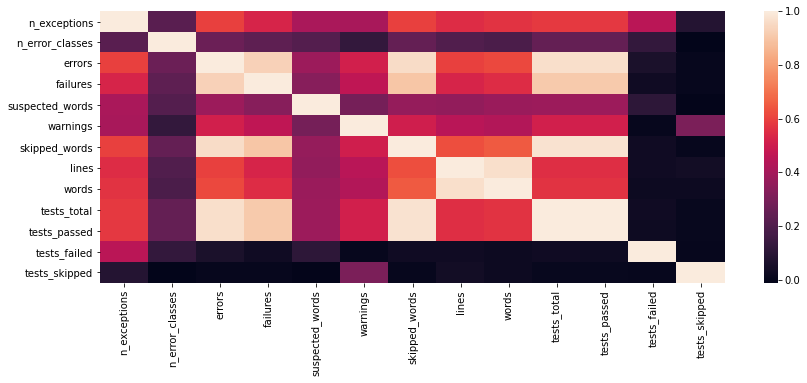

In [178]:
sns.heatmap(job_parsed[['n_exceptions', 'n_error_classes', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped']].corr())

**Exceptions thrown**

<AxesSubplot:>

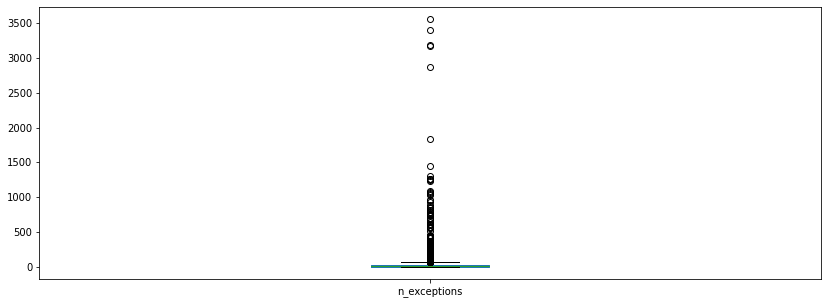

In [159]:
job_parsed.n_exceptions.plot(kind="box")

<AxesSubplot:>

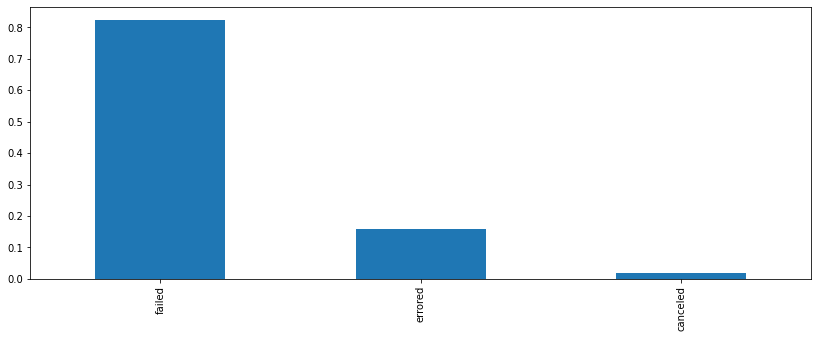

In [171]:
job_parsed[job_parsed.n_exceptions > 500].state.value_counts(normalize=True).plot(kind="bar")

**Errors**

<AxesSubplot:>

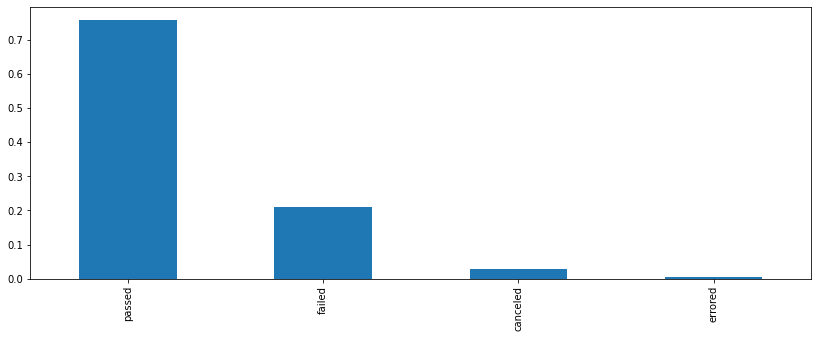

In [164]:
job_parsed[job_parsed.n_error_classes > 0].state.value_counts(normalize=True).plot(kind="bar")

**Warnings**

<AxesSubplot:>

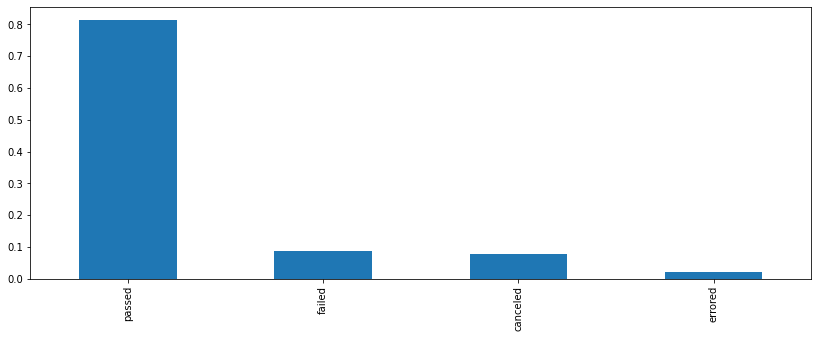

In [165]:
job_parsed[job_parsed.warnings > 0].state.value_counts(normalize=True).plot(kind="bar")

**Failures**

<AxesSubplot:>

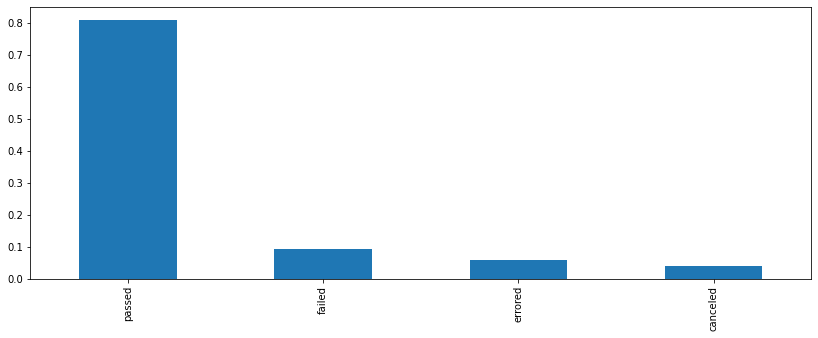

In [166]:
job_parsed[job_parsed.failures > 0].state.value_counts(normalize=True).plot(kind="bar")

**Number of test failed**

<AxesSubplot:xlabel='tests_failed'>

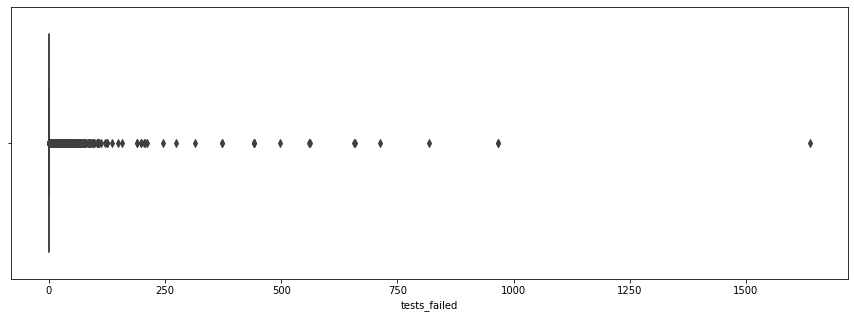

In [45]:
sns.boxplot(x=job_parsed.tests_failed)

<AxesSubplot:>

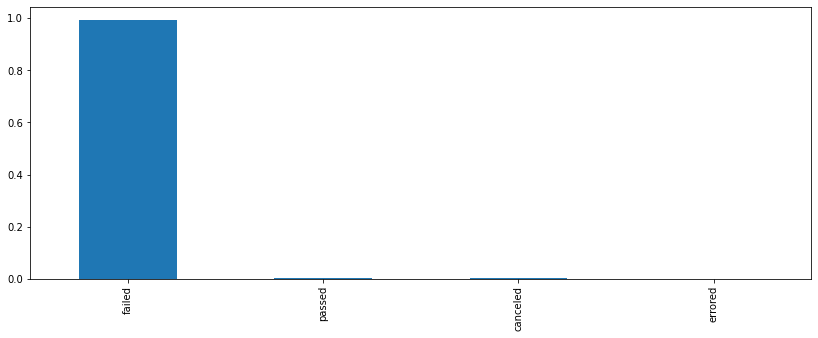

In [167]:
job_parsed[job_parsed.tests_failed > 0].state.value_counts(normalize=True).plot(kind="bar")

**Distribution of build tools**

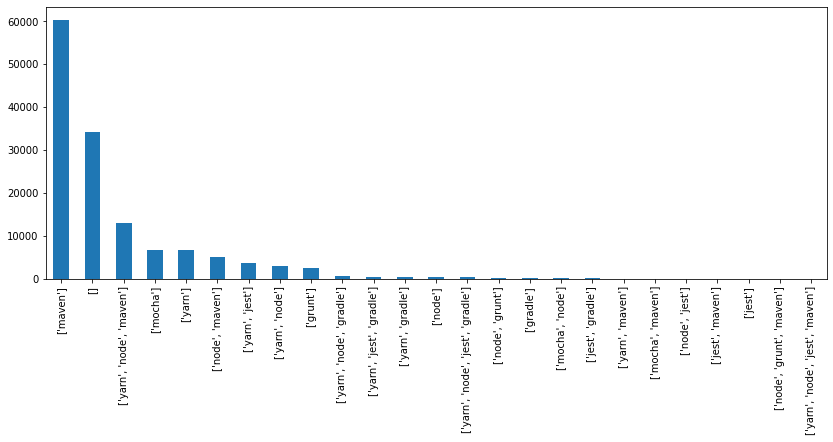

In [70]:
plt.figure()
ax = job_parsed.build_tool_str.value_counts().sort_values(ascending=False).plot(kind="bar")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.savefig(f"{figure_folder}/log-parsing-analysis/distribution_tools.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Yarn and Maven?**

In [47]:
yarn_maven = job_parsed[(job_parsed.build_tool.apply(lambda x: "yarn" in x)) \
           & (job_parsed.build_tool.apply(lambda x: "maven" in x))]

In [48]:
yarn_maven.build_target.value_counts()

BUILD    11537
CI        1445
Name: build_target, dtype: int64

In [49]:
yarn_maven.build_tool_str.value_counts()

['yarn', 'node', 'maven']            12969
['yarn', 'maven']                       14
['yarn', 'node', 'jest', 'maven']        2
Name: build_tool_str, dtype: int64

<AxesSubplot:>

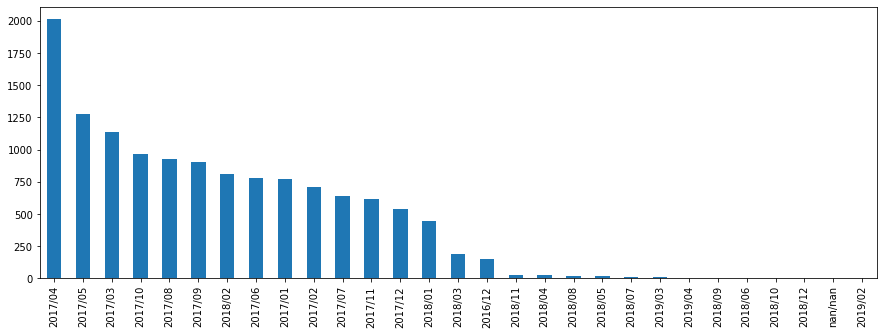

In [50]:
yarn_maven.year_month.value_counts().plot(kind="bar")

**Distribution build tools over time**

<Figure size 1008x360 with 0 Axes>

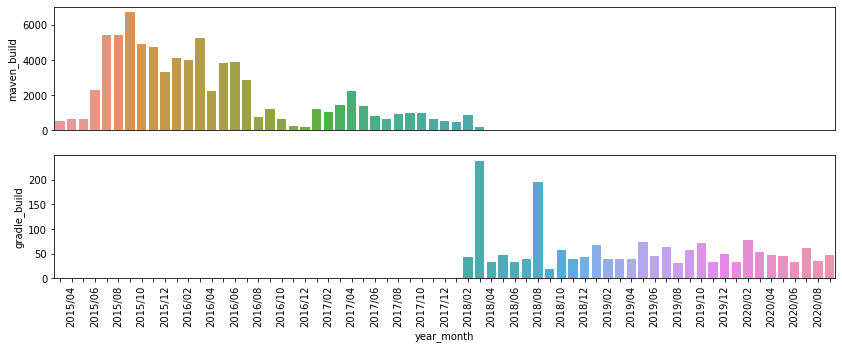

In [83]:
tools = ["maven","gradle"]
plt.figure()
fig, axes = plt.subplots(nrows=len(tools), ncols=1, sharex=True)
for i, tool in enumerate(tools):
    ax = sns.barplot(data=job_parsed[job_parsed.year_month != "nan/nan"]\
                     .groupby("year_month")[f"{tool}_build"].sum().reset_index(),\
                x='year_month', y=f"{tool}_build", ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    if(i < len(tools) - 1):
        ax.get_xaxis().set_visible(False)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f"{figure_folder}/log-parsing-analysis/maven-gradle.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

<Figure size 1008x360 with 0 Axes>

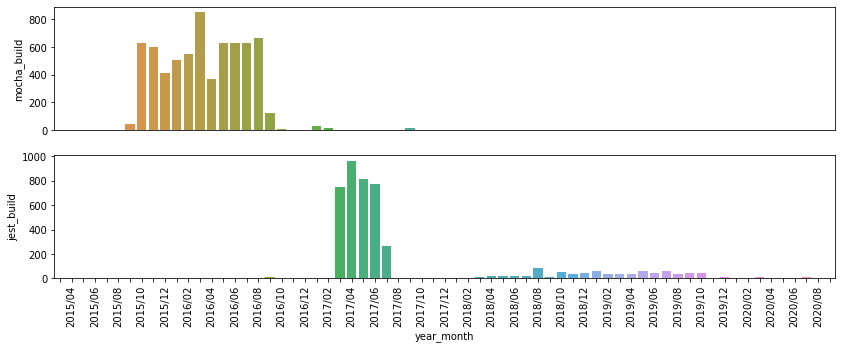

In [81]:
tools = ["mocha","jest"]
plt.figure()
fig, axes = plt.subplots(nrows=len(tools), ncols=1, sharex=True)
for i, tool in enumerate(tools):
    ax = sns.barplot(data=job_parsed[job_parsed.year_month != "nan/nan"]\
                     .groupby("year_month")[f"{tool}_build"].sum().reset_index(),\
                x='year_month', y=f"{tool}_build", ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    if(i < len(tools) - 1):
        ax.get_xaxis().set_visible(False)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f"{figure_folder}/log-parsing-analysis/mocha-jest.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

<Figure size 1008x360 with 0 Axes>

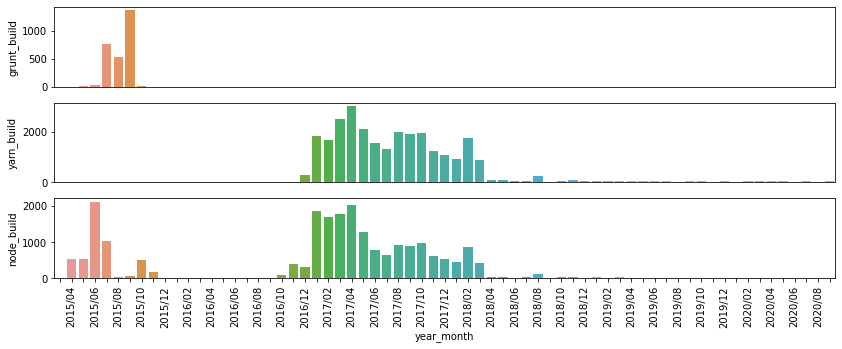

In [82]:
tools = ["grunt","yarn", "node"]
plt.figure()
fig, axes = plt.subplots(nrows=len(tools), ncols=1, sharex=True)
for i, tool in enumerate(tools):
    ax = sns.barplot(data=job_parsed[job_parsed.year_month != "nan/nan"]\
                     .groupby("year_month")[f"{tool}_build"].sum().reset_index(),\
                x='year_month', y=f"{tool}_build", ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    if(i < len(tools) - 1):
        ax.get_xaxis().set_visible(False)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f"{figure_folder}/log-parsing-analysis/node-grunt-yarn.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Investigation of empty tools**

In [62]:
empty_build_tool = job_parsed[job_parsed.n_build_tools == 0]

In [63]:
empty_build_tool.state.value_counts(normalize=True)

canceled    0.554363
passed      0.244540
errored     0.177440
failed      0.023657
Name: state, dtype: float64

In [85]:
empty_build_tool_passed = empty_build_tool[empty_build_tool.state.isin(["passed"])]

In [86]:
empty_build_tool_failed = empty_build_tool[empty_build_tool.state.isin([ "failed"])]

**Are failed jobs with no build tool assigned shorter?**

<ipython-input-124-13b19ebeccd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_build_tool_failed["Build tool"] = "No tool detected"
<ipython-input-124-13b19ebeccd7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_empty_build_tool_failed["Build tool"] = "Tool detected"


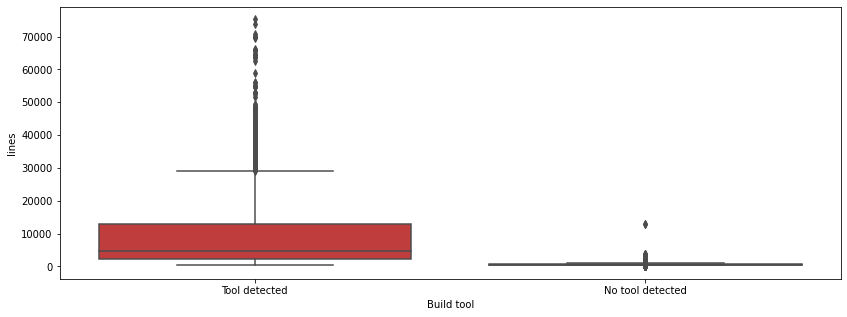

In [124]:
empty_build_tool_failed["Build tool"] = "No tool detected"
no_empty_build_tool_failed = job_parsed[(job_parsed.n_build_tools > 0)&(job_parsed.state.isin([ "failed"]))]
no_empty_build_tool_failed["Build tool"] = "Tool detected"

merged = no_empty_build_tool_failed.append(empty_build_tool_failed)
#Plot
plt.figure()
sns.boxplot(data=merged, x="Build tool", y="lines", color= matplotlib.colors.to_rgb('tab:red'))
plt.savefig(f"{figure_folder}/log-parsing-analysis/failed_empty_tool_lines.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

<AxesSubplot:xlabel='lines'>

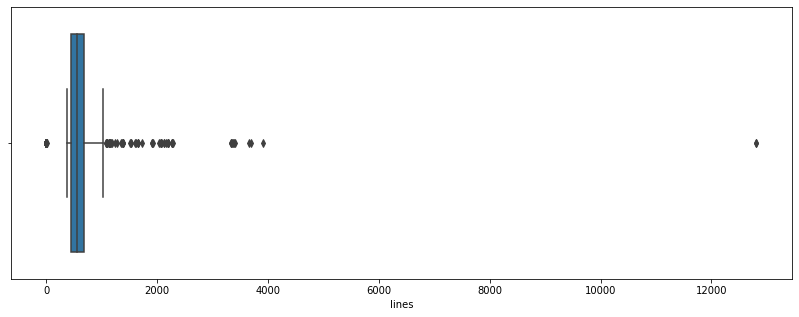

In [90]:
sns.boxplot(x=empty_build_tool_failed.lines)

Investigating outliers...

In [92]:
empty_build_tool_failed[empty_build_tool_failed.lines>12000]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,n_exceptions,n_error_classes,n_build_tools,year_month,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,Build tool
92794,224238385,BUILD,[],False,6057.0,6049.0,2.0,26.0,0.0,12812.0,117538.0,[],[],0.0,0.0,0.0,0.0,[],[],224238385,224238384,2017-04-21 06:47:03+00:00,2017-04-21 06:45:15.621000+00:00,2017-04-21 06:52:54+00:00,22555.1,failed,2018-06-02 07:26:11.198000+00:00,cb8951cc74049f7699eb3ffd76576d480e5be205,64745289,Force upgrade to Trusty,refs/heads/test/tv/ramfs,https://github.com/SonarSource/sonarqube/compa...,0,0,0,2017/04,False,False,False,False,False,False,False,No tool detected
97231,224253133,BUILD,[],False,6057.0,6049.0,2.0,26.0,0.0,12811.0,117569.0,[],[],0.0,0.0,0.0,0.0,[],[],224253133,224253132,2017-04-21 07:52:04+00:00,2017-04-21 07:50:28.328000+00:00,2017-04-21 07:57:54+00:00,22566.1,failed,2018-06-02 07:26:33.687000+00:00,c14b3f8e342fb0c30af3ef38970e42d3aeacb8a7,64750067,BUILD: fix travis install,refs/heads/test/tv/ramfs,https://github.com/SonarSource/sonarqube/compa...,0,0,0,2017/04,False,False,False,False,False,False,False,No tool detected


224253133, 224238385 are the only ones with no exceptions or error classes. They failed in running an intialization script which produced many lines of errors, and indeed the number of failure words is high.

**Passed jobs with no build tool**

In [93]:
empty_build_tool_passed.build_canceled_open_pr_on_branch.value_counts(normalize=True)

False    0.550468
True     0.449532
Name: build_canceled_open_pr_on_branch, dtype: float64

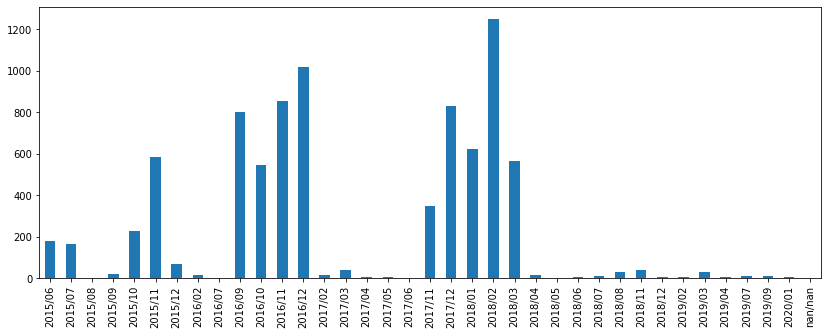

In [95]:
data = empty_build_tool_passed.year_month
ax = data.value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

<AxesSubplot:>

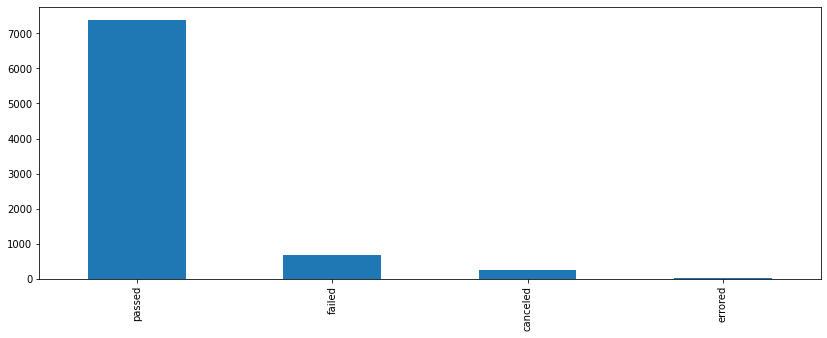

In [96]:
empty_build_tool_passed = empty_build_tool_passed.merge(builds[["id", "state"]], left_on="buildid", right_on="id", suffixes=["_job", "_build"])
empty_build_tool_passed.state_build.value_counts().plot(kind="bar")

In [97]:
empty_build_tool_passed = empty_build_tool_passed[~empty_build_tool_passed.build_canceled_open_pr_on_branch]

In [101]:
(empty_build_tool_passed.lines == 1).sum() / len(empty_build_tool_passed)

0.4181184668989547

In [115]:
empty_build_tool_passed[empty_build_tool_passed.lines > 1].shape

(2672, 45)

<ipython-input-123-310823bf7deb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_build_tool_passed_no_reason["Build tool"] = "No tool detected"
<ipython-input-123-310823bf7deb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_empty_build_tool_passed["Build tool"] = "Tool detected"


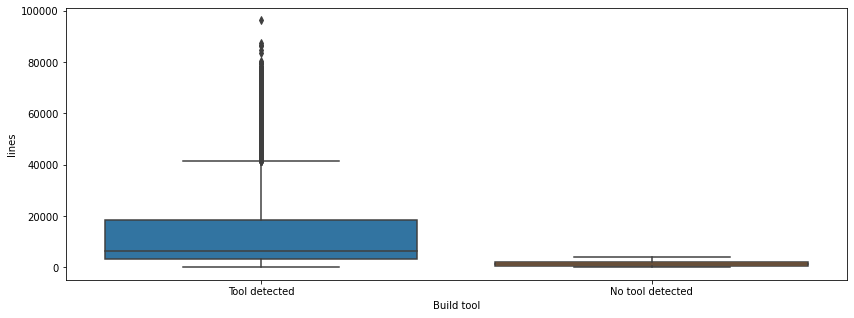

In [123]:
empty_build_tool_passed_no_reason = empty_build_tool_passed[(empty_build_tool_passed.lines>1)&\
                                                           (~empty_build_tool_passed.build_canceled_open_pr_on_branch)]
empty_build_tool_passed_no_reason["Build tool"] = "No tool detected"
no_empty_build_tool_passed = job_parsed[(job_parsed.n_build_tools > 0)&(job_parsed.state.isin(["passed"]))]
no_empty_build_tool_passed["Build tool"] = "Tool detected"

merged = no_empty_build_tool_passed.append(empty_build_tool_passed_no_reason)
#Plot
plt.figure()
sns.boxplot(data=merged, x="Build tool", y="lines")
plt.savefig(f"{figure_folder}/log-parsing-analysis/passed_empty_tool_lines.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Empty log file**

In [106]:
empty_log = job_parsed[job_parsed.lines==1]

In [103]:
len(job_parsed[job_parsed.lines==1]) / len(job_parsed)

0.07408218538066767

<AxesSubplot:>

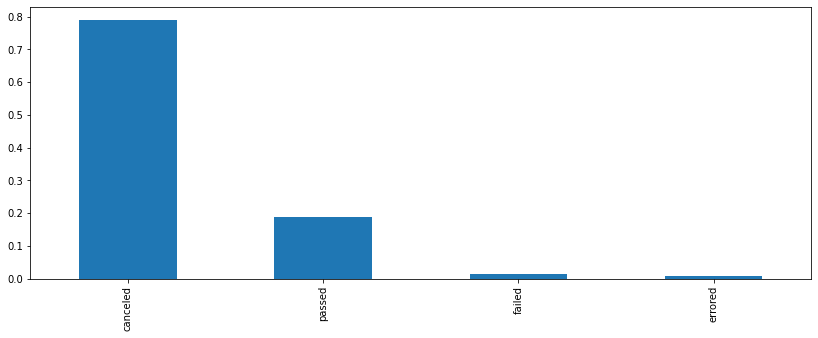

In [105]:
job_parsed[job_parsed.lines==1].state.value_counts(normalize=True).plot(kind="bar")

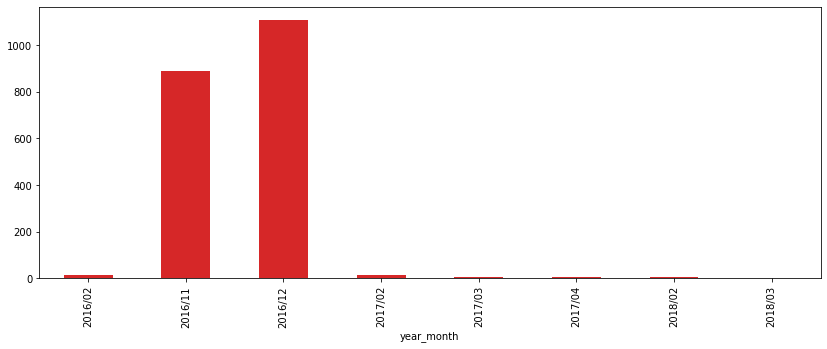

In [111]:
#Plot
plt.figure()
empty_log[empty_log.state.isin(["passed", "failed"])].groupby("year_month").job_id.count().plot(kind="bar", color=["tab:red"])
plt.savefig(f"{figure_folder}/log-parsing-analysis/empty_log_passed_failed_time_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Sum of tests == total?**

In [ ]:
not_na_job_parsed = job_parsed[~job_parsed.tests_total.isna()]
not_na_job_parsed[not_na_job_parsed.tests_total != (not_na_job_parsed.tests_passed + not_na_job_parsed.tests_skipped + not_na_job_parsed.tests_failed)]

We fixed this small bug. Just forgot to update passed tests for lines reporting only total, failed and skipped

**Reason for failing tests**

In [125]:
failed_jobs = job_parsed[job_parsed.state == "failed"]

In [126]:
len(failed_jobs[failed_jobs.tests_failed > 0]) / len(failed_jobs)

0.5084104707872997

In [130]:
len(failed_jobs[failed_jobs.failures > 0]) / len(failed_jobs)

0.9419727281775654

In [131]:
len(failed_jobs[failed_jobs.suspected_words > 0]) / len(failed_jobs)

0.9865631531800537

In [127]:
len(failed_jobs[failed_jobs.exceptions.apply(lambda x: len(x) > 0)]) / len(failed_jobs)

0.8093958395540958

In [128]:
len(failed_jobs[failed_jobs.error_classes.apply(lambda x: len(x) > 0)]) / len(failed_jobs)

0.350253807106599

In [132]:
len(failed_jobs[failed_jobs.errors > 0]) / len(failed_jobs)

0.9653627948641386

**Failed builds with no apparent reason**

In [ ]:
failed_jobs = job_parsed[job_parsed.state == "failed"]

In [ ]:
failed_jobs[(failed_jobs.tests_failed == 0) &\
           (failed_jobs.exceptions == "[]") &\
           (failed_jobs.error_classes == "[]")&\
           (failed_jobs.errors == 0) &\
           (failed_jobs.failures == 0) &\
           (failed_jobs.suspected_words == 0)].build_tool.value_counts()

All the failed build have no build tool and failed in the travis script before invoking one of the tools

**Gradle tests?**

In [135]:
gradle = job_parsed[job_parsed.build_tool.apply(lambda x: "gradle" in x)]
gradle[(gradle.tests_total > 0) & (gradle.build_target=="BUILD")]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,n_exceptions,n_error_classes,n_build_tools,year_month,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build
8,483557470,BUILD,"[yarn, node, jest, gradle]",False,2.0,5.0,3.0,12.0,0.0,1817.0,7496.0,"[FileNotFound, FileNotFound]",[],12.0,12.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",483557470,483557469,2019-01-23 19:21:55+00:00,2019-01-23 19:21:25.852000+00:00,2019-01-23 19:47:24+00:00,38847.1,passed,2019-01-23 19:47:24.747000+00:00,3dc969856b59dc52b5b2e855d8b2387d4670ff36,145686653,DOCS formatting glitches & minor rewording (#1...,refs/pull/3187/merge,https://github.com/SonarSource/sonarqube/pull/...,2,0,4,2019/01,False,True,False,True,False,True,True
14,432603264,BUILD,"[yarn, node, jest, gradle]",False,3.0,4.0,1.0,10.0,0.0,1377.0,5174.0,[],[],10.0,10.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",432603264,432603263,2018-09-24 18:21:55+00:00,2018-09-24 18:21:18.408000+00:00,2018-09-24 18:36:47+00:00,38673.1,passed,2018-09-24 18:36:47.761000+00:00,90c9dee7d1cd167658bb6be1a7554f9883d9b0c0,130098008,Do not execute Cirrus tasks on dogfood feature...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,0,0,4,2018/09,False,True,False,True,False,True,True
48,461930847,BUILD,"[yarn, node, jest, gradle]",False,3.0,21.0,3.0,10.0,0.0,1718.0,7158.0,"[FileNotFound, FileNotFound]",[],12.0,12.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",461930847,461930846,2018-11-30 19:21:46+00:00,2018-11-30 19:21:14.748000+00:00,2018-11-30 19:46:05+00:00,38791.1,passed,2018-11-30 19:46:05.178000+00:00,9320207525a2645d835f19ff61c8dcb656f83e18,139137990,Fix Travis build,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2,0,4,2018/11,False,True,False,True,False,True,True
66,431620486,BUILD,"[yarn, node, jest, gradle]",False,3.0,4.0,1.0,10.0,1.0,1384.0,5152.0,[],[],2.0,2.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",431620486,431620485,2018-09-21 18:21:43+00:00,2018-09-21 18:21:10.187000+00:00,2018-09-21 18:36:19+00:00,38672.1,passed,2018-09-21 18:36:19.794000+00:00,64d76164768f4b74d6bdc714191f65567baf8d10,129801286,rewrite account app in ts,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,0,0,4,2018/09,False,True,False,True,False,True,True
104,728138257,BUILD,"[yarn, node, jest, gradle]",False,3.0,10.0,12.0,29.0,0.0,1603.0,6218.0,[TestTimedOut],[],305.0,304.0,1.0,0.0,[server:sonar-main:test],"['yarn', 'node', 'jest', 'gradle']",728138257,728138256,2020-09-17 20:08:20+00:00,2020-09-17 20:07:47.760000+00:00,2020-09-17 20:24:47+00:00,39417.1,failed,2020-09-17 20:24:47.608000+00:00,eb9c975e8e8fd64381fd8d1ebea75989d298ac37,224801880,BUILD-811 Move ci builds to sonarqube team gcp...,refs/heads/branch-7.9,https://github.com/SonarSource/sonarqube/compa...,1,0,4,2020/09,False,True,False,True,False,True,True
110,430441025,BUILD,"[yarn, node, gradle]",False,4.0,10.0,1.0,3.0,0.0,1007.0,3665.0,[],"[Assertion, Assertion]",1171.0,1169.0,2.0,0.0,[sonar-plugin-api:test],"['yarn', 'node', 'gradle']",430441025,430441024,2018-09-19 08:52:56+00:00,2018-09-19 08:52:19.612000+00:00,2018-09-19 09:05:57+00:00,38669.1,failed,2018-09-19 09:05:57.714000+00:00,d26b9987f51a4866933b908dcc1d9a616994d28f,129436680,Revert unexpected changes in sonar-vsts/packag...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,0,2,3,2018/09,False,True,False,False,False,True,True
247,492864642,BUILD,"[yarn, node, jest, gradle]",False,2.0,5.0,7.0,12.0,0.0,1683.0,6406.0,"[FileNotFound, FileNotFound]",[],12.0,12.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",492864642,492864641,2019-02-13 19:21:47+00:00,2019-02-13 19:21:10.957000+00

**Compare with Travistorrent**

In [ ]:
folder = "../../../../tmp"
df = pd.read_csv(f"{folder}/travis_projects.csv", index_col=0)
df

In [ ]:
sonar_travis = df[df.gh_project_name == "SonarSource/sonarqube"]

In [ ]:
sonar_travis.columns

In [ ]:
sonar_travis[["tr_job_id", "tr_log_num_tests_failed"]]

In [ ]:
job_our_travis = job_parsed[["job_id", "tests_failed","tests_skipped", "tests_passed","tests_total", "build_tool"]].merge(sonar_travis[["tr_log_analyzer", "tr_job_id", "tr_log_num_tests_failed", "tr_log_num_tests_run","tr_log_num_tests_ok", "tr_log_num_tests_skipped"]], left_on="job_id", right_on="tr_job_id")

In [ ]:
job_our_travis.shape

In [ ]:
job_our_travis[job_our_travis.tests_failed == job_our_travis.tr_log_num_tests_failed]

In [ ]:
x[(x.tests_passed != x.tr_log_num_tests_run) & (~x.tr_log_num_tests_run.isna())]

In [ ]:
job_parsed[job_parsed.build_tool.apply(lambda x: "gradle" in x)]

In [138]:
new_parsing = pd.read_csv("../../local_log_parsing/jobs_log_metrics_final.csv", index_col=0)

In [139]:
new_parsing.shape

(1845, 18)

In [141]:
new_parsing[new_parsing.tests_total == 6]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks
8,449986640,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,24,43,4,30,13,9659,23388,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
11,511467601,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,26,12,0,1701,6798,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
12,483557470,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,3,12,0,1817,7496,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
37,503750852,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,26,12,0,1708,6774,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
81,461930847,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,21,3,10,0,1718,7158,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
129,472424947,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,10,3,10,0,1711,7008,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
141,472425002,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,10,3,10,0,1717,7026,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
176,492331709,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,13,7,12,0,1851,6733,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
181,504865488,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,26,12,0,1697,6757,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
216,460178328,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,22,3,11,0,1870,8190,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]


In [397]:
job_parsed[job_parsed.build_tool.apply(lambda x: "gradle" in x)].tests_passed.mean()

776.9691056910569

In [137]:
maven_ids = job_parsed[(job_parsed.build_tool.apply(lambda x: "gradle" in x))].job_id.unique()
with open('gradle_to_reparse.txt', 'w') as f:
    for item in maven_ids:
        f.write("%s\n" % item)

In [386]:
job_parsed[(job_parsed.build_tool.apply(lambda x: "gradle" in x)) &\
           (job_parsed.tests_total == 0)&\
           (job_parsed.build_tool.apply(lambda x: not "yarn" in x)) &\
           (job_parsed.build_target == "BUILD")].head(100)

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,duration,n_exceptions,n_error_classes,n_build_tools,year_month,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,Build tool
100041,654868754,BUILD,[gradle],False,3.0,1.0,2.0,3.0,1.0,1676.0,7223.0,[],[],0.0,0.0,0.0,0.0,[],654868754,654868753,2020-02-25 12:19:26+00:00,2020-02-25 12:18:57.611000+00:00,2020-02-25 12:29:45+00:00,39258.1,passed,2020-02-25 12:29:45.938000+00:00,348572e537d52313ea949fae228ca5cb6ddf8f9a,199639121,Update run_iris.sh,refs/heads/feature/wad/do-not-merge-do-not-merge,https://github.com/SonarSource/sonarqube/compa...,619.0,0,0,1,2020/02,False,True,False,False,False,False,False,Tool detected
100044,539623711,BUILD,"[jest, gradle]",False,2.0,3.0,2.0,19.0,10.0,2450.0,11514.0,[],[],0.0,0.0,0.0,0.0,[],539623711,539623710,2019-05-31 09:33:00+00:00,2019-05-31 09:32:28.592000+00:00,2019-05-31 09:38:11+00:00,39002.1,failed,2019-05-31 09:38:12.011000+00:00,27fd75a5d1db1e617e15f609d8e0ea884442592c,163042815,Merge branch 'patch-1' of https://github.com/f...,refs/pull/3209/merge,https://github.com/SonarSource/sonarqube/pull/...,311.0,0,0,2,2019/05,False,True,False,True,False,False,False,Tool detected
100047,599916834,BUILD,"[jest, gradle]",False,2.0,2.0,21.0,40.0,1.0,2583.0,11358.0,[],[],0.0,0.0,0.0,0.0,[],599916834,599916833,2019-10-19 00:42:27+00:00,2019-10-19 00:41:57.220000+00:00,2019-10-19 00:55:24+00:00,39156.1,passed,2019-10-19 00:55:24.750000+00:00,9f78b9190e37cc87190161d19ed6e91396810261,181935164,fix: Test check against new wording,refs/pull/3230/merge,https://github.com/SonarSource/sonarqube/pull/...,777.0,0,0,2,2019/10,False,True,False,True,False,False,False,Tool detected
100054,654868799,BUILD,[gradle],False,2.0,1.0,1.0,3.0,1.0,1679.0,7219.0,[],[],0.0,0.0,0.0,0.0,[],654868799,654868798,2020-02-25 12:19:32+00:00,2020-02-25 12:19:01.138000+00:00,2020-02-25 12:29:35+00:00,39259.1,passed,2020-02-25 12:29:35.624000+00:00,7529bd4d4466fde00f4059cd2f143e92cd90cfee,199639128,Update run_iris.sh,refs/pull/3236/merge,https://github.com/SonarSource/sonarqube/pull/...,603.0,0,0,1,2020/02,False,True,False,False,False,False,False,Tool detected
100058,666960186,BUILD,"[jest, gradle]",False,3.0,6.0,8.0,17.0,36.0,6180.0,33799.0,"[FileNotFound, FileNotFound]",[],0.0,0.0,0.0,0.0,[],666960186,666960185,2020-03-25 20:04:41+00:00,2020-03-25 20:04:04.946000+00:00,2020-03-25 20:31:42+00:00,39283.1,passed,2020-03-25 20:31:42.675000+00:00,93bf42f81310013436f2d5ef60b60d8714a32f5f,203545004,increase analysis log level,refs/heads/branch-7.9,https://github.com/SonarSource/sonarqube/compa...,1621.0,2,0,2,2020/03,False,True,False,True,False,False,False,Tool detected
100091,728138203,BUILD,[gradle],False,99.0,8.0,3.0,8.0,46.0,9162.0,58707.0,[FileNotFound],[],0.0,0.0,0.0,0.0,[],728138203,728138202,2020-09-17 20:08:36+00:00,2020-09-17 20:07:36.568000+00:00,2020-09-17 20:30:12+00:00,39416.1,passed,2020-09-17 20:30:12.567000+00:00,2545e06845915284dfcacc23ed857a5f0cc2e5ab,224801847,SONAR-13867 revert,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,1296.0,1,0,1,2020/09,False,True,False,False,False,False,False,Tool detected
100175,634913519,BUILD,[gradle],False,2.0,6.0,14.0,15.0,8.0,2304.0,9377.0,[FileNotFound],[],0.0,0.0,0.0,0.0,[],634913519,634913518,2020-01-13 10:23:19+00:00,2020-01-09 19:46:24.834000+00:00,2020-01-13 10:48:28+00:00,39215.1,passed,2020-01-13 10:48:28.057000+00:00,f61e29bce771e56f8d45ad07a235c0399a1a9772,193210665,Fix codesmell typo (#2404),refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,1509.0,1,0,1,2020/01,False,True,False,False,False,False,False,Tool detected
100240,634848325,BUILD,[gradle],False,2.0,1.0,36.0,5

In [377]:
job_parsed[job_parsed.job_id == 723216122]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,duration,n_exceptions,n_error_classes,n_build_tools,year_month,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,Build tool
105670,723216122,WEB_TESTS,"[yarn, gradle]",False,14.0,3.0,3.0,29.0,0.0,1429.0,4173.0,[],[],2421.0,2421.0,0.0,0.0,[],723216122,723216120,2020-09-01 20:08:30+00:00,2020-09-01 20:07:18.217000+00:00,2020-09-01 20:17:34+00:00,39404.2,passed,2020-09-01 20:17:36.236000+00:00,4bb0bd7d590110c6bc977eb480b30c67ef15e04d,223005970,Move ci builds to sonarqube team gcp project.,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,544.0,0,0,2,2020/09,False,True,False,False,False,True,False,Tool detected
